Validation of CameraCalibration class.

In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
corners = None

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = mpimg.imread(fname)               # Read to RGB pixel format
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
 
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()
# Clean up workspace: keep only objpoints and imgpoints
del corners, gray, images, objp

from classes.CameraCalibration import CameraCalibration
cal = CameraCalibration(imgpoints = imgpoints, objpoints = objpoints, img_size=(1280,720))
cal.save('camera_cal/validation.p')

Validation of CameraCalibration. 

Testing undistort and handling of image collections.

RGBA image shape: (720, 1280, 4) and size: (1280, 720)


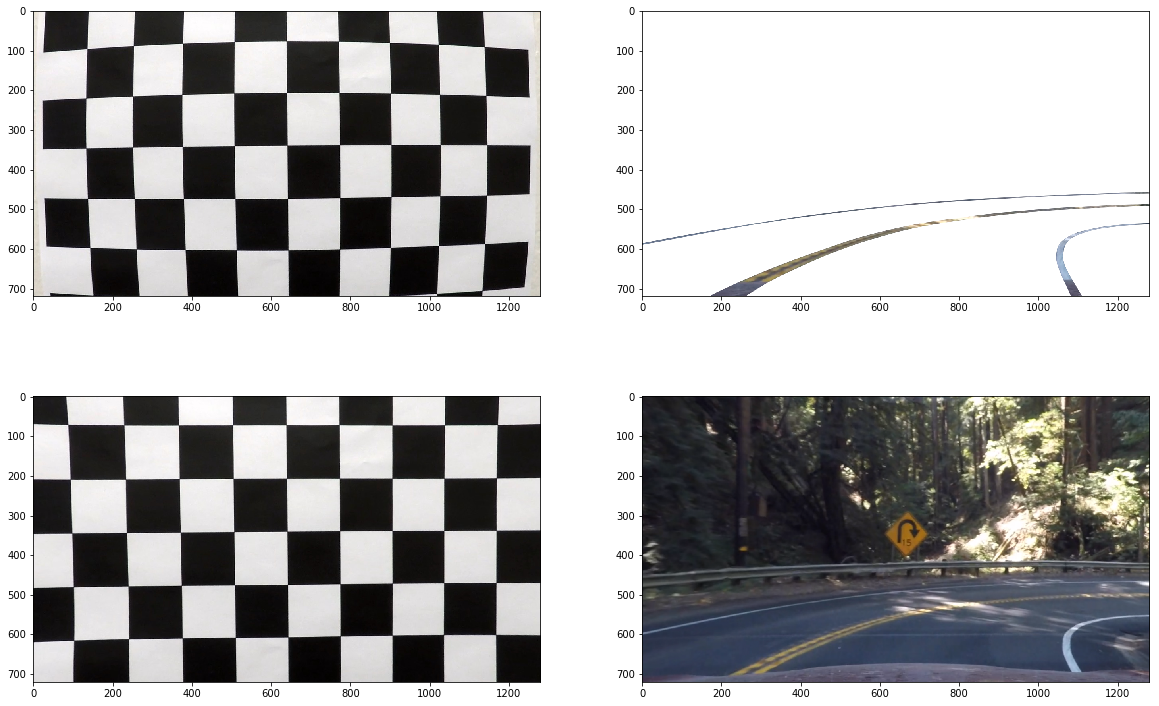

In [1]:
import matplotlib.pyplot as plt
from classes.RoadImage import RoadImage
from classes.CameraCalibration import CameraCalibration

%matplotlib inline

# Flatten() creates a collection of 1 image (shape (1,720,1280,3))
img = RoadImage('camera_cal/calibration1.jpg').flatten()
cal = CameraCalibration('camera_cal/validation.p')
undist = img.undistort(cal)

# Load RGBA image
rgba = RoadImage('training/hard_turn_annotated.png')
print('RGBA image shape:',rgba.shape, 'and size:', rgba.get_size())
rgbaundist = rgba.undistort(cal)

f, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20,13))
ax1.imshow(img[0])
ax3.imshow(undist[0])
rgba.show(ax2)
rgbaundist.show(ax4, alpha=False)

Validation of RoadImage class.
Constructor, numpy interoperability, cropping and casting.

In [ ]:
from classes.RoadImage import RoadImage

# Correctly handle ambiguous vector of RGB values: silently accepted if src_cspace is given.
k= RoadImage(np.zeros(shape=(3,3)), src_cspace='RGB')
# Seen as RGB vector of pixels
print('3x3 input seen as 3 color pixels. Nb of channels =',RoadImage.image_channels(k))

# Load from file demo
d = RoadImage('test_images/straight_lines1.jpg')
# Load from file into existing buffer, resizing, convert to gray, convert dtype automatically
b = RoadImage(np.empty(shape=(64,64,1), dtype=np.float32), 'test_images/straight_lines1.jpg')
# Load from file into existing buffer, resizing, convert colorspace to LUV.
a = RoadImage(np.empty(shape=(72,128,3), dtype=np.uint8), 'test_images/straight_lines1.jpg', cspace='LUV')
# Extract subimage
#c = d.convert_color('LAB')[400:500, 540:740]
c = d[400:500, 540:740].convert_color('LAB')
d_child = d.find_child((RoadImage.crop,((540,400),(740,500))))
print('c.parent is None:',c.parent is None)
print('c.parent is child of d:',c.parent is d_child)
print('c.crop_area:',c.crop_area)
print('d_child.crop_area:',d_child.crop_area)
print('d.get_crop(d):', d.get_crop(d))
print('c.shape:',c.shape)
print('c.size:',c.size)

e = c[25:75, 50:150]
for p in e.parents():
#    print(e.find_op(p, normal=True))
    print('p.shape and e.get_crop(e,parents...):',p.shape, e.get_crop(p))

print('Children of d =')
print(d.list_children())

import matplotlib.pyplot as plt
%matplotlib inline


f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20,13))
# Load from file
ax1.imshow(d)
# Load to existing buffer: resize 64x64 convert to grayscale float32
ax2.imshow(b, cmap='gray')
# Load to existing buffer: resize 128x72x3 uint8, convert colorspace to LUV  
ax3.imshow(a)
ax4.imshow(c)

Validation of RoadImage class.

Locking / unlocking of parents.

In [ ]:
from classes.RoadImage import RoadImage
import numpy as np

# Crop, flatten and channel do not make parent read-only
k= RoadImage(np.zeros(shape=(2,2,1)), src_cspace='GRAY')
k.binary=False
print('k is writeable:', k.flags.writeable)
c=k[0:1]
print('c.shape =',c.shape)
print('c.crop_area =',c.get_crop(k))
f=k.flatten()
print(k.list_children())
print('k.flatten().shape =',f.shape)
ch=k.channel(0)
print('k.channel(0).shape =',ch.shape)
print('k.channel(0).crop_area =',ch.get_crop(k))
print('k is writeable:', k.flags.writeable)
n=k.normalize()
print('normalize zeros:\n')#,n.__repr__())
print('k is writeable:', k.flags.writeable)
print(k.list_children())
normal=False
print('crop op:',c.find_op(k, normal))
print('flatten_op:',f.find_op(k, normal))
print('channel_op:',ch.find_op(k, normal))
print('normalize_op:',n.find_op(k,normal))
print('k has only auto-updating children:',RoadImage.__has_only_autoupdating_children__(k))
try:
    k[0,0] = 1
except ValueError:
    print('Writing into k generates an exception.')
print('deleting hard reference to n.')
del n
print('k has only auto-updating children:',RoadImage.__has_only_autoupdating_children__(k))
k[0,0]=1

Validation of RoadImage class. 

Color conversion. Children and parents.

In [ ]:
# Define a timing decorator
from functools import wraps
from time import time


def timing(f):
    @wraps(f)
    def wrapper(*args, **kwargs):
        start = time()
        result = f(*args, **kwargs)
        end = time()
        print('Elapsed time: {}'.format(end-start) )
        return result
    return wrapper


from classes.RoadImage import RoadImage
a = RoadImage('test_images/test1.jpg')
print('No children yet:',a.list_children())
print('Colorspace is: '+a.colorspace)

print('\nMemorization test 1: unreferenced temporaries are discarded and rebuilt.')
@timing
def f():
    a.convert_color('YCC')
   
# Check that convert_color is destroyed and rebuilt
f()
f()

print('\nMemorization test 2: referenced images are linked and reused (time is shorter).')
@timing
def g():
    return a.convert_color('YCC')

b = g()
b = g()

print('Only one child: ',a.list_children())
b = a.find_child((RoadImage.convert_color,'YCC'))
c = b.convert_color('RGB')
d = c.to_grayscale().normalize(inplace=True)
print('d.shape =',d.shape) 
print('Children: ',a.list_children())

print('b.parent is a:',b.parent is a)
print('c.parent is b:',c.parent is b)
print('d.parent is c:',d.parent is c)
print('d was built with:',d.find_op())
print('a to d ops:',d.find_op(a))

import matplotlib.pyplot as plt
%matplotlib inline

f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20,13))
# Image from file (RGB)
a.show(ax1)
# Image from file converted to YCC, then back to RGB
c.show(ax2)
# YCC image
b.show(ax3)
# Grayscale image
d.show(ax4)

Validation of RoadImage class. 

Conversion to float and to int

In [ ]:
from classes.RoadImage import RoadImage
a = RoadImage('test_images/test1.jpg')
print('No children yet:',a.list_children())
print('Data type is: '+str(a.dtype))

b = a.to_float()
c = a.to_int()
d = b.to_int()
print('Children: ',a.list_children())

print('Is a, parent of b?',b.parent is a)
print('Is b, a?',b is a)
print('Is a, parent of c?',c.parent is a)
print('Is c, a?',c is a)
print('Is c parent of d?',d.parent is c)
print('Is b, d?',d is b)
print('a to d ops:',d.find_op(a))

import matplotlib.pyplot as plt
%matplotlib inline

f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20,13))
# Image from file (uint8) 
a.show(ax1)
# float converted
b.show(ax2)
# int converted
c.show(ax3)
# int to float, back to int converter
d.show(ax4)

Validation of RoadImage class. Per channel operations (gradient, normalize).

Take opportunity of large number of generated children to test find_common_ancestor

In [ ]:
from classes.RoadImage import RoadImage

img = RoadImage('test_images/test2.jpg', cspace='HLS')
print(img.shape)
f1 = img.flatten()
f2 = f1.flatten()
print(f2.shape)
print(f2 is f1)
print(f1 is img)
print(f1.crop_area)
print('Children of img: ', img.list_children())
grads = img.gradients(['angle','mag','x','y'], sobel_kernel=9)
(a,m,x,y) = grads
print(a.shape)
print(type(a))

import numpy as np
print("Magnitude: min=",np.min(m),' max=',np.max(m))
m.normalize(perchannel=True, inplace=True)
print("Normalized magnitude: min=",np.min(m),' max=',np.max(m))
x.normalize(perchannel=True, perline=True, inplace=True)
y.normalize(perchannel=True, perline=True, inplace=True)
print('Children of img: ', img.list_children())

print('\nfind_common_ancestors( [grada, gradm, gradx, grady, copy of gradm]):')
mcopy = m.copy()
lst = grads + [mcopy]
ancestors, index = RoadImage.find_common_ancestor(lst)
print('\nancestors and index:')
for i, anc in enumerate(ancestors): print(i,'\t',anc.shape)
print(index)
print('\noperations from ancestor to list element:')
for i,image in enumerate(lst):
    print(image.find_op(ancestors[index[i]]))

# Make collection
print('\nmake_collection:')
coll = RoadImage.make_collection(grads)
print('coll.type =',type(coll))
print('coll.shape =',coll.shape)

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20,13))
# Angle of gradient 
a.show(ax1)
# Magnitude of gradient
ax2.imshow(m)
# x gradient
ax3.imshow(np.abs(x))
# y gradient
ax4.imshow(np.abs(y))

Validation of class RoadImage.

Validation of thresholding of images and gradients.

In [ ]:
from classes.RoadImage import RoadImage
import numpy as np

img = RoadImage('test_images/straight_lines1.jpg', cspace='HLS')
print('Loaded shape:',img.shape)
# We have per channel min and max (for H,L and S)
mini = np.array([0.0627, 0.762, 0.75])
maxi = np.array([0.0863, 1.0,   1.0])
copy = img.copy()
print('copy.dtype =',copy.dtype)
copy.threshold(mini, maxi, inplace=True)
print('copy.binary =',copy.binary)
print('copy.gradient =',copy.gradient)
print('match_shape:',RoadImage.__match_shape__(mini.shape, copy.shape))

mask = RoadImage('training/straight_mask.png')
# Make mask truly binary
mask.threshold(mini=0.5, inplace=True)
print('mask colorspace:', mask.colorspace)
print('mask is binary:', mask.binary)
print('mask.shape =',mask.shape)
print('mask is grayscale:',RoadImage.is_grayscale(mask))
print('mask dtype:', mask.dtype)
# Not inplace
imini = mini.reshape((1,)+mini.shape)
imaxi = maxi.reshape((1,)+maxi.shape)
# Small constant ensures that mini > maxi in areas where mask = 0
# Needs img.to_float to have an effect.

# Combine gradients to make a 2D HLS image:
minimask = 0.0001+np.tensordot(mask,imini, axes=([2],[0])) 
maximask = np.tensordot(mask,imaxi, axes=([2],[0])) 
thresh = img.to_float().threshold(minimask, maximask)

# Add gradient info
grads = img.gradients(['angle','mag','x','y'], sobel_kernel=9)
(a,m,x,y) = grads
a.threshold(mini=np.array([0.266,0.269,0.265]),maxi=np.array([0.64,0.661,0.685]), inplace=True)
m.normalize(perchannel=True, inplace=True)\
    .threshold(np.array([0.352,0.298,0.327]),np.array([0.623,0.707,0.705]),inplace=True)
x.normalize(perchannel=True, perline=True, inplace=True)\
    .threshold(np.array([0.304,0.3,0.302]),np.array([0.687,0.707,0.707]),inplace=True)
y.normalize(perchannel=True, perline=True, inplace=True)\
    .threshold(np.array([0.28,0.278,0.282]),np.array([0.684,0.707,0.706]),inplace=True)

g = RoadImage.make_collection([x,y]).sum(axis=(0,3)).reshape(mask.shape)
#        .threshold(mini=0.5, inplace=True)
print('min(g) =',np.min(g), 'max(g) =',np.max(g))
print('a is gradient:', a.gradient)
print('m is gradient:', m.gradient)
print('x is gradient:', x.gradient)
print('g is gradient:', g.gradient)
print('g is binary:',g.binary)
gmask = np.abs(g) + RoadImage.make_collection([a,m]).sum(axis=(0,3)).reshape(mask.shape)
gmask.normalize(inplace=True).threshold(mini=0.3, inplace=True)
g.threshold(mini=0.0001, maxi=gmask, inplace=True)
print('g is gradient:', g.gradient)
print('g is binary:',g.binary)
print('g.shape =',g.shape)

# Display img and masks as HLS
import matplotlib.pyplot as plt
%matplotlib inline

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows=4, ncols=2, figsize=(20,26))
# Mask applied to signed gradient x+y, computed based on absolute value of gradients
gmask.show(ax5)
# Thresholded HLS masks
copy.show(ax6)
thresh.show(ax7)
g.show(ax8)
# Gradients of H,L and S
a.show(ax1)
m.show(ax2)
x.show(ax3)
y.show(ax4)
